# Predicting Heart Disease

Link to Competittion: https://www.kaggle.com/competitions/playground-series-s6e2/overview

## Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (10, 5)

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc, accuracy_score, mean_squared_error, classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.tree import plot_tree

from common import *

In [2]:
from platform import python_version
print('python: ', python_version())
print('pandas: ', pd.__version__)
print('numpy: ', np.__version__)
import matplotlib
print('matplotlib: ', matplotlib.__version__)
print('seaborn: ', sns.__version__)
import sklearn
print('sklearn: ', sklearn.__version__)
print('xgboost: ', xgb.__version__)

python:  3.13.11
pandas:  2.3.3
numpy:  2.3.5
matplotlib:  3.10.8
seaborn:  0.13.2
sklearn:  1.8.0
xgboost:  3.1.3


## Load data

In [3]:
orig_train_df = pd.read_csv('archive/train.csv')
orig_test_df = pd.read_csv('archive/test.csv')

## Call the pipeline

In [4]:
train_df = (orig_train_df
          .pipe(copy_data)
          .pipe(clean_data)
          # .pipe(remove_outliers)
          # .pipe(remove_duplicates)
          .pipe(make_new_features)
          # .pipe(encode_all_the_things)
          # .pipe(fill_nas)
           )

In [5]:
test_df = (orig_test_df
          .pipe(copy_data)
          .pipe(clean_data)
          # .pipe(remove_outliers)
          # .pipe(remove_duplicates)
          .pipe(make_new_features)
          # .pipe(encode_all_the_things)
          # .pipe(fill_nas)
           )

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   age                      630000 non-null  int64  
 1   sex                      630000 non-null  int64  
 2   chest_pain_type          630000 non-null  int64  
 3   bp                       630000 non-null  int64  
 4   cholesterol              630000 non-null  int64  
 5   fbs_over_120             630000 non-null  int64  
 6   ekg_results              630000 non-null  int64  
 7   max_hr                   630000 non-null  int64  
 8   exercise_angina          630000 non-null  int64  
 9   st_depression            630000 non-null  float64
 10  slope_of_st              630000 non-null  int64  
 11  number_of_vessels_fluro  630000 non-null  int64  
 12  thallium                 630000 non-null  int64  
 13  heart_disease            630000 non-null  int64  
dtypes: f

## Create some new features

In [7]:
features = get_features(train_df)

In [8]:
# Pairwise generation was too much, need to scale back
# for f1 in features:
#     for f2 in features:
#         if f1 != f2:
#             train_df[f"{f1}_x_{f2}"] = train_df[f1] * train_df[f2]
#             train_df[f"{f1}_/_{f2}"] = train_df[f1] / (train_df[f2] + 0.0001)

#             test_df[f"{f1}_x_{f2}"] = test_df[f1] * test_df[f2]
#             test_df[f"{f1}_/_{f2}"] = test_df[f1] / (test_df[f2] + 0.0001)

# top 20 features by importance
# ['max_hr_/_thallium',
 # 'chest_pain_type_x_slope_of_st',
 # 'sex_x_chest_pain_type',
 # 'chest_pain_type_x_thallium',
 # 'sex_x_slope_of_st',
 # 'st_depression_x_slope_of_st',
 # 'slope_of_st_x_number_of_vessels_fluro',
 # 'max_hr_/_number_of_vessels_fluro',
 # 'chest_pain_type_x_number_of_vessels_fluro',
 # 'chest_pain_type_/_max_hr',
 # 'sex_x_exercise_angina',
 # 'max_hr_/_chest_pain_type',
 # 'max_hr_/_exercise_angina',
 # 'exercise_angina_x_slope_of_st',
 # 'slope_of_st_x_thallium',
 # 'number_of_vessels_fluro_x_thallium',
 # 'age_x_number_of_vessels_fluro',
 # 'sex_/_max_hr',
 # 'age_x_sex',
 # 'thallium_/_max_hr']

In [9]:
def create_some_new_features(passed_df):
    tmp_df = passed_df.copy()
    # tmp_df['max_hr_/_thallium'] = tmp_df['max_hr'] / tmp_df['thallium'] + 0.0001
    # tmp_df['chest_pain_type_x_slope_of_st'] = tmp_df['chest_pain_type'] * tmp_df['slope_of_st']
    # tmp_df['sex_x_chest_pain_type'] = tmp_df['sex'] * tmp_df['chest_pain_type']

    tmp_df['bp_sq'] = tmp_df['bp'] ** 2
    tmp_df['bp_rt'] = np.sqrt(tmp_df['bp'])

    tmp_df['max_hr_sq'] = tmp_df['max_hr'] ** 2
    tmp_df['max_hr_rt'] = np.sqrt(tmp_df['max_hr'])

    tmp_df['cholesterol_sq'] = tmp_df['cholesterol'] ** 2
    tmp_df['cholesterol_rt'] = np.sqrt(tmp_df['cholesterol'])

    return tmp_df

In [10]:
train_df = create_some_new_features(train_df)
test_df = create_some_new_features(test_df)

## Choose target and features

In [11]:
target = get_target()

In [12]:
features = get_features(train_df)

In [13]:
categorical_features = ['thallium', 'chest_pain_type']

In [14]:
numerical_features = [f for f in features if f not in categorical_features]

In [15]:
categorical_features

['thallium', 'chest_pain_type']

In [16]:
numerical_features

['age',
 'sex',
 'bp',
 'cholesterol',
 'fbs_over_120',
 'ekg_results',
 'max_hr',
 'exercise_angina',
 'st_depression',
 'slope_of_st',
 'number_of_vessels_fluro',
 'bp_sq',
 'bp_rt',
 'max_hr_sq',
 'max_hr_rt',
 'cholesterol_sq',
 'cholesterol_rt']

In [17]:
train_df[categorical_features] = train_df[categorical_features].astype('category')
test_df[categorical_features] = test_df[categorical_features].astype('category')

In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   age                      630000 non-null  int64   
 1   sex                      630000 non-null  int64   
 2   chest_pain_type          630000 non-null  category
 3   bp                       630000 non-null  int64   
 4   cholesterol              630000 non-null  int64   
 5   fbs_over_120             630000 non-null  int64   
 6   ekg_results              630000 non-null  int64   
 7   max_hr                   630000 non-null  int64   
 8   exercise_angina          630000 non-null  int64   
 9   st_depression            630000 non-null  float64 
 10  slope_of_st              630000 non-null  int64   
 11  number_of_vessels_fluro  630000 non-null  int64   
 12  thallium                 630000 non-null  category
 13  heart_disease            630000 non-null  in

In [19]:
train_df

,age,sex,chest_pain_type,bp,cholesterol,fbs_over_120,ekg_results,max_hr,exercise_angina,st_depression,slope_of_st,number_of_vessels_fluro,thallium,heart_disease,bp_sq,bp_rt,max_hr_sq,max_hr_rt,cholesterol_sq,cholesterol_rt
0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,1,23104,12.328828,24964,12.569805,57121,15.459625
1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,0,15625,11.180340,29241,13.076697,105625,18.027756
2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,0,25600,12.649111,22801,12.288206,35344,13.711309
3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,0,17956,11.575837,22500,12.247449,52441,15.132746
4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,1,19600,11.832160,15625,11.180340,54756,15.297059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629995,56,0,1,110,226,0,0,132,0,0.0,1,0,7,0,12100,10.488088,17424,11.489125,51076,15.033296
629996,54,1,4,128,249,1,2,150,0,0.0,2,0,3,0,16384,11.313708,22500,12.247449,62001,15.779734
629997,67,1,4,130,275,0,0,149,0,0.0,1,2,7,1,16900,11.401754,22201,12.206556,75625,16.583124
629998,52,1,4,140,199,0,2,157,0,0.0,1,0,6,1,19600,11.832160,24649,12.529964,39601,14.106736


## Encoding

In [20]:
X_train = train_df[features].copy()
y_train = train_df[target]

X_test = test_df[features].copy()

In [21]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

## XGBoost

In [22]:
xgb_model = XGBClassifier(n_estimators=2000, early_stopping_rounds=50, device='cuda', random_state=123, enable_categorical=True)

In [23]:
xgb = xgb_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=100)

[0]	validation_0-logloss:0.53000
[100]	validation_0-logloss:0.27018
[107]	validation_0-logloss:0.27020


In [24]:
n_best = xgb_model.best_iteration

In [25]:
n_best

57

In [26]:
preds = xgb_model.predict_proba(X_train)[:,1]

In [27]:
final_xgb_model = XGBClassifier(n_estimators=n_best, device='cuda', random_state=123, enable_categorical=True)

In [28]:
_ = final_xgb_model.fit(X_train, y_train)

In [29]:
xgb_scores = cross_val_score(
    final_xgb_model, 
    X_train, 
    y_train, 
    cv=10, 
    scoring='roc_auc'
)

In [30]:
print(f"ROC AUC: {roc_auc_score(y_train, preds):.5f}")

ROC AUC: 0.95675


In [31]:
importance_df = pd.DataFrame({'Features': features, 'Importance': xgb_model.feature_importances_})

In [32]:
importance_df.sort_values(by='Importance', ascending=False)[:20]['Features'].tolist()

['thallium',
 'chest_pain_type',
 'number_of_vessels_fluro',
 'exercise_angina',
 'slope_of_st',
 'sex',
 'max_hr',
 'st_depression',
 'ekg_results',
 'age',
 'cholesterol',
 'bp',
 'fbs_over_120',
 'bp_sq',
 'bp_rt',
 'max_hr_sq',
 'max_hr_rt',
 'cholesterol_sq',
 'cholesterol_rt']

<Axes: xlabel='Importance', ylabel='Features'>

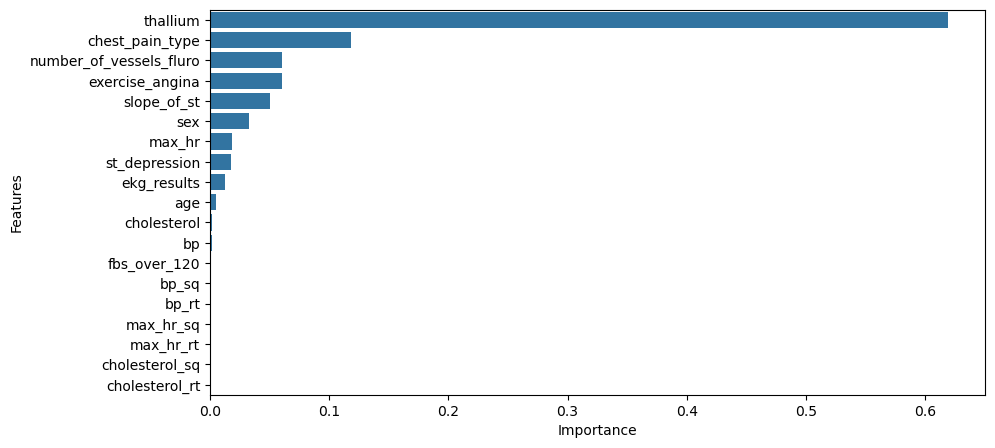

In [33]:
sns.barplot(data=importance_df.sort_values(by='Importance', ascending=False)[:25], y='Features', x='Importance')

## Run Predictions

In [34]:
final_preds = np.zeros(len(X_test))

final_preds = final_xgb_model.predict_proba(X_test)[:,1]

## Prepare Submission

In [35]:
# Create submission
submission_df = pd.DataFrame({
  'id': orig_test_df['id'],
  'Heart Disease': final_preds
})

In [36]:
last_submission = pd.read_csv(find_last_submission_file())

In [37]:
# submission_df.to_csv('./archive/submission_01.csv', index=False)

In [38]:
submission_df.head()

,id,Heart Disease
0,630000,0.964454
1,630001,0.010309
2,630002,0.986333
3,630003,0.004980
4,630004,0.207671


<Axes: xlabel='Heart Disease', ylabel='Count'>

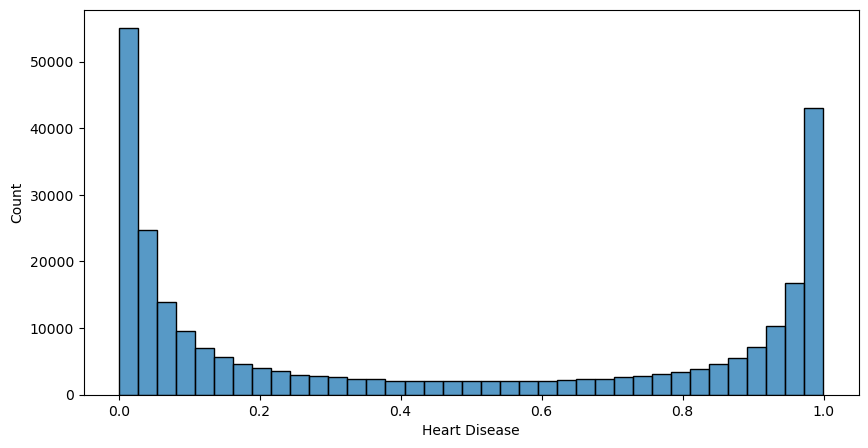

In [39]:
sns.histplot(submission_df['Heart Disease'])

In [40]:
if np.allclose(last_submission['Heart Disease'], submission_df['Heart Disease']):
    # they are the same, don't same
    print('skipping save')
else:
    submission_df.to_csv(find_next_submission_file(), index=False)
    print('saving file')

saving file
